# Reinforcement Learning - SARSA Algorithm

## Step 1 - Import Libraries

In [1]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note need to 'pip install gym', and 'pip install gym[toy_text]' 
                                 # or 'pip install gym\[toy_text\]' if zsh does nor recongize the first command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version

from IPython import display # for displaying environment states
import time # for slowing down rendering of states by adding small time delays
#%matplotlib inline

numpy: 1.23.3
gym: 0.26.0
matplotlib: 3.6.0


## Step 2 - Setup the Environment

We will use FrozenLake-v1 environment. Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake (when option is_slippery=True). However, in this example we will use is_slippery=False). 

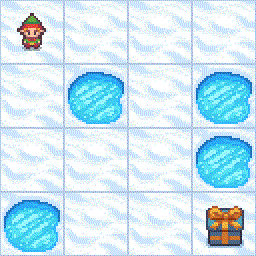

Source: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/?highlight=frozen+lake

##### Setup environment

In [2]:
# Setup environment
env = gym.make(id='FrozenLake-v1', # choose one of the existing environments
               desc=None, # Used to specify custom map for frozen lake. E.g., desc=["SFFF", "FHFH", "FFFH", "HFFG"].
               map_name='4x4', # ID to use any of the preloaded maps. E.g., '4x4', '8x8'
               is_slippery=False, # True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

By convention, if render_mode is:
- <b>None (default):</b> no render is computed.
- <b>human:</b> render return None. The environment is continuously rendered in the current display or terminal. Usually for human consumption.
- <b>rgb_array:</b> return frames representing the state of the environment. A frame is a numpy.ndarray with shape (x, y, 3), representing RGB values for an x-by-y pixel image.
- <b>ansi:</b> Return a list of strings (str) or StringIO.StringIO containing a terminal-style text representation for each time step. The text can include newlines and ANSI escape sequences (e.g. for colors).

##### Show environment description (map) as an array

- S = Start
- F = Frozen
- H = Hole
- G = Goal

In [3]:
# Show environment description (map) as an array
env.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

You can see that the map matches the gif image above, when it comes locations of Start(S), Frozen(F), Hole(H) and Goal(G).

##### You'll see later that the environment state is simply a number representing a current location of the agent
- state(observation) = current_row * nrows + current_col

        | 0 | 1 | 2 | 3 |
        | 4 | 5 | 6 | 7 |
        | 8 | 9 |10 |11 |
        |12 |13 |14 |15 |
 

##### Show state (observation) space and action space

In [4]:
# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

State(Observation) space: Discrete(16)
Action space: Discrete(4)


- The observation space contains 16 discrete positions, since it is made up of 4x4 squares (see gif image above)
- The agent takes a 1-element vector for actions. The action space is (dir), where dir decides direction to move in, which can be:
    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

##  Step 3 - Interacting with the Environment

Functions of the Env class that help the agent interact with the environment.

- <b>reset:</b> This function resets the environment to its initial state, and returns the observation of the environment corresponding to the initial state.
- <b>step:</b> This function takes an action as an input and applies it to the environment, which leads to the environment transitioning to a new state. The step function returns four things:
    - <b>observation/state:</b> The state(observation) of the environment.
    - <b>reward:</b> The reward that you can get from the environment after executing the action that was given as the input to the step function.
    - <b>done:</b> Whether the episode has been terminated. If true, you may need to end the simulation or reset the environment to restart the episode.
    - <b>info:</b> This provides additional information depending on the environment, such as number of lives left, or general information that may be conducive in debugging.

##### Reset environment to initial state

In [5]:
# Specify seed for reproducability (optional)
#env.action_space.seed(42)

# Reset environment to initial state
#state, info = env.reset(seed=42)
state, info = env.reset()

# Print the state(observstion) of the environment
print("The initial state is {}".format(state))
#print("The initial information {}".format(info))

The initial state is 0


You can see that the initial state is 0. I.e., we have put the agent back into the Start position.

##### Perform 20 random steps to show how the agent walks around the environment (no training at this stage)

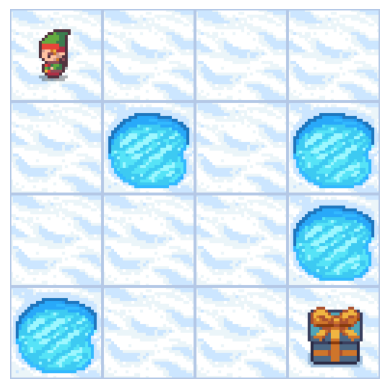

In [6]:
# Cycle through 20 random steps redering and displaying the agent inside the environment each time
for _ in range(20):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Sample a random action from the entire action space
    random_action = env.action_space.sample()
    
    # Pass the random action into the step function
    state, reward, done, _, info = env.step(random_action)
        
    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done=True, i.e., when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display current state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        # Reset environment
        state, info = env.reset()

# Close environment 
env.close()

---

## Step 4 - Train a model, i.e., find optimal Policy (π)

### SARSA algorithm

#### $Q(S_{t},A_{t}) = Q(S_{t},A_{t}) + \alpha [R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})]$


- Q - Q-function (note, Q stands for "Quality")
- $S_{t}$ - current state(observation)
- $A_{t}$ - current action
- $R_{t+1}$ - reward received following current action
- $S_{t+1}$ - next state(observation)
- $A_{t+1}$ - next action
- $\alpha$ (alpha) - learning rate parameter
- $\gamma$ (gamma) - discount factor parameter

### Q-Learning algorithm: 

#### $Q(S_{t},A_{t}) = Q(S_{t},A_{t}) + \alpha [R_{t+1} + \gamma max_{a} Q(S_{t+1},a) - Q(S_{t},A_{t})]$


- Q - Q-function (note, Q stands for "Quality")
- $S_{t}$ - current state(observation)
- $A_{t}$ - current action
- $R_{t+1}$ - reward received following current action
- $S_{t+1}$ - next state(observation)
- $\alpha$ (alpha) - learning rate parameter
- $\gamma$ (gamma) - discount factor parameter
- $max_{a} Q(S_{t+1},a)$ - maximum value for the next state(observation) across the possible action space

##### Initialize parameters

In [7]:
# Q-function parameters
alpha = 0.7   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 50000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.05   # the lowest epsilon allowed to decay to
decay_rate = 0.001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves


##### Initialize the Q-table

In [8]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 16 x 4
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

##### Define functions to choose actions and to update Q
- SARSA is an on-policy algorithm. Hence, we will use the same epsilong-greedy strategy to act and to update the Q table. 
    - epsilon-greedy function will give us an action
    - while update_Q function will update Q after each interation (since SARSA uses Temporal Difference (TD) approach)

In [9]:
# This is our acting policy (epsilon-greedy), for the agent to do exploration and exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, otherwuse exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action

In [10]:
# This function is to update the Qtable (also based on epsilon-greedy) because the next_action is decided by epsilon-greedy policy
def update_Q(Qtable, state, action, reward, next_state, next_action):
    # 𝑄(𝑆𝑡,𝐴𝑡)=𝑄(𝑆𝑡,𝐴𝑡)+𝛼[𝑅𝑡+1+𝛾𝑄(𝑆𝑡+1,𝐴𝑡+1)−𝑄(𝑆𝑡,𝐴𝑡)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * (Qtable[next_state][next_action]) - Qtable[state][action])
    return Qtable

##### Define another function that gives us action based on greedy policy (we will use it when evaluating results)

In [11]:
# Always go for the highest value (state,action) pair
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

##### Define a traning function

In [12]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        # Choose an action using previously defined epsilon-greedy policy
        action = epsilon_greedy(Qtable, state, epsilon)
        
        for t in range(n_max_steps):
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Choose next action
            next_action=epsilon_greedy(Qtable, next_state, epsilon)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state, next_action)
            
            # Update current state 
            state = next_state
            action = next_action
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
    # Return final Q-table
    return Qtable

#### Find the optimal policy by running the training algorith (Train)

In [13]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[0.22089871, 0.19421263, 0.77376454, 0.12172807],
       [0.23768224, 0.        , 0.81450551, 0.23642861],
       [0.33589581, 0.857375  , 0.23555431, 0.24703495],
       [0.23558818, 0.        , 0.23074286, 0.23638096],
       [0.44727317, 0.12806598, 0.        , 0.68954364],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.3484695 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.04897286, 0.        , 0.06094246, 0.20508294],
       [0.17838419, 0.90236183, 0.68313439, 0.        ],
       [0.80234627, 0.95      , 0.        , 0.42251748],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.86222928, 0.95      , 0.52361078],
       [0.9025    , 0.95      , 1.        , 0.53905278],
       [0.        , 0.        , 0.        , 0.        ]])

First row corresponds to state 0 (starting point) and we pick the action (LEFT, DOWN, RIGHT, UP) that has the highest value.

The next row in the Q-table represents state 1, which is the second square from the left on the top row. It shows that action to go DOWN from that square has 0 value, which is as expected since going DOWN would lead us into a whole.

In summary, the Q-table tells us the value of each state-action pair. Hence, we know what is the best action (one with the highest value) to take at each state.

## Step 5 - Evaluate the value function to see if we managed to find the best policy
We will use our final Q-table and eval_greedy function that returns an action with the highest value for an input state

##### Evaluate agent by calculating mean rewards over a specified number of episodes (say, 100 episodes)

In [14]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward += reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [15]:
n_eval_episodes=100
mean_reward, std_reward = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")

Mean Reward = 1.00 +/- 0.00


We can see that for each of the 100 episodes we got a reward of 1. This means that our agent has reached the goal without failure in every attempt. Success!

##### Now let's also render the steps that the agent takes using our optimised Q-table

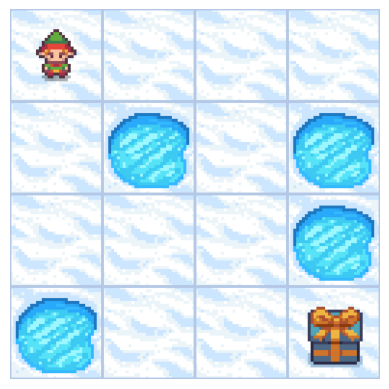

In [15]:
# Cycle through 19 steps redering and displaying environment state each time
state, info = env.reset()
for _ in range(19):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)

    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()

##### Success! Our agent has learnt to successfully reach the goal without falling into a hole

# End of Program